In [1]:
# Common imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 5)

# Список литературы

1. "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems", Géron, A., 2017, *O'Reilly Media*
2. "An Introduction to Statistical Learning: With Applications in R.", Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshirani, 2014, *Springer Publishing Company, Incorporated*
3. [Sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix)
4. "Scaling to Very Very Large Corpora for Natural Language Disambiguation", Michele Banko and Eric Brill, 2001, *Microsoft Research*

# Разреженные матрицы

**Разреженная матрица** - матрица, в которой большая часть элементов нули. 

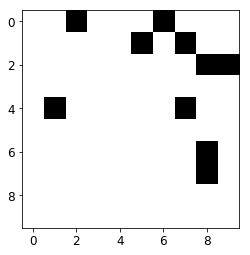

In [2]:
from sklearn.preprocessing import binarize
from scipy import sparse

sm = binarize(sparse.rand(10, 10, density=0.1, random_state=42))
plt.imshow(sm.todense(), cmap=matplotlib.cm.binary)

In [3]:
density = sm.nnz / (sm.shape[0] * sm.shape[1])
print("Density (плотность): ", density)
print("Sparsity (разреженность): ", 1 - density)

Density (плотность):  0.1
Sparsity (разреженность):  0.9


In [4]:
# плотное представление матрицы
sm.todense()

matrix([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [5]:
print("Dense matrix memory usage:", sm.todense().nbytes)
print("CSR matrix memory usage:", sm.data.nbytes + sm.indices.nbytes + sm.indptr.nbytes)

Dense matrix memory usage: 800
CSR matrix memory usage: 164


In [6]:
big_sm = binarize(sparse.rand(1000, 1000, density=0.001, random_state=42))
print("Dense matrix memory usage (kB):", big_sm.todense().nbytes / 1024)
print("CSR matrix memory usage (kB):", (big_sm.data.nbytes + big_sm.indices.nbytes + big_sm.indptr.nbytes) / 1024)

Dense matrix memory usage (kB): 7812.5
CSR matrix memory usage (kB): 15.62890625


Для хранения плотной матрицы требуется объем памяти, пропорциональный $m \times n$, где $m$ - количество строк, $n$ - количество столбцов (т.к. данные хранятся как список списков). Т.е. хранить большие матрицы дорого, а когда они более чем на $99\%$ заполнены нулями, еще и невыгодно. Для компрессии таких матриц используют разреженные матрицы. К сожалению, за это приходится платить необходимостью адаптировать алгоритмы для работы с разреженными матрицами. 

Существующие форматы для хранения разреженных матриц: DOK, LIL, COO, CSR, CSC, ...

## DOK, LIL, COO

Эффективны: для быстрого создания и изменения матриц

Не эффективны: для арифметических операций

In [7]:
tm = binarize(np.random.rand(10, 10), threshold=0.9)
print("Плотность:", tm[tm > 0].size / (tm.shape[0] * tm.shape[1]))
tm

Плотность: 0.09


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Dictionary of keys (DOK)

In [8]:
dok_sm = sparse.dok_matrix(tm, shape=tm.shape)
dok_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Dictionary Of Keys format>

In [9]:
print("Как в теории хранятся данные\n")
dict(dok_sm.items())

Как в теории хранятся данные



{(0, 1): 1.0,
 (1, 1): 1.0,
 (3, 3): 1.0,
 (3, 4): 1.0,
 (4, 3): 1.0,
 (5, 0): 1.0,
 (5, 2): 1.0,
 (5, 5): 1.0,
 (6, 9): 1.0}

### List of lists (LIL)

In [10]:
lil_sm = sparse.lil_matrix(tm, shape=tm.shape)
lil_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in LInked List format>

In [11]:
print("Как в теории хранятся данные\n")
fmt = "%-6s | %s"
print(fmt % ("row_id", "данные"))
print("-" * 50)
for row_id in range(lil_sm.shape[0]):
    print(fmt % (
        row_id, 
        list(zip(lil_sm.rows[row_id], lil_sm.data[row_id]))
    ))

Как в теории хранятся данные

row_id | данные
--------------------------------------------------
0      | [(1, 1.0)]
1      | [(1, 1.0)]
2      | []
3      | [(3, 1.0), (4, 1.0)]
4      | [(3, 1.0)]
5      | [(0, 1.0), (2, 1.0), (5, 1.0)]
6      | [(9, 1.0)]
7      | []
8      | []
9      | []


### Coordinate list (COO)

In [12]:
coo_sm = sparse.coo_matrix(tm, shape=tm.shape)
coo_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>

In [13]:
print("Как в теории хранятся данные\n")
[tpl for tpl in zip(coo_sm.row, coo_sm.col, coo_sm.data)]

Как в теории хранятся данные



[(0, 1, 1.0),
 (1, 1, 1.0),
 (3, 3, 1.0),
 (3, 4, 1.0),
 (4, 3, 1.0),
 (5, 0, 1.0),
 (5, 2, 1.0),
 (5, 5, 1.0),
 (6, 9, 1.0)]

## CSR, CSC

Эффективны: для арифметических операций

Не эффективны: для быстрого создания и изменения матриц

### Compressed sparse row (CSR)

In [14]:
csr_sm = sparse.csr_matrix(tm, shape=tm.shape)
csr_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [15]:
tm

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
print("A: ", csr_sm.data)
print("IA: ", csr_sm.indptr)
print("JA: ", csr_sm.indices)

A:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
IA:  [0 1 2 2 4 5 8 9 9 9 9]
JA:  [1 1 3 4 3 0 2 5 9]


### Compressed sparse column (CSC)

In [17]:
csc_sm = sparse.csc_matrix(tm, shape=tm.shape)
csc_sm

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Column format>

In [18]:
tm

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [19]:
print("A: ", csc_sm.data)
print("IA: ", csc_sm.indptr)
print("JA: ", csc_sm.indices)

A:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
IA:  [0 1 3 4 6 7 8 8 8 8 9]
JA:  [5 0 1 5 3 4 3 5 6]


## Особенности scipy.sparse

In [20]:
rows, cols = csr_sm.nonzero()

In [21]:
%%time
sm = sparse.lil_matrix(csc_sm.shape)
for row_id, col_id in zip(rows, cols):
    sm[row_id, col_id] = 1

CPU times: user 100 µs, sys: 38 µs, total: 138 µs
Wall time: 142 µs


In [22]:
%%time
sm = sparse.csr_matrix(csc_sm.shape)
for row_id, col_id in zip(rows, cols):
    sm[row_id, col_id] = 1

CPU times: user 5.07 ms, sys: 388 µs, total: 5.45 ms
Wall time: 127 ms


/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### но, ...

In [23]:
%%time
sm = sparse.lil_matrix(tm.shape)
for row_id, col_id in zip(rows, cols):
    sm[row_id, col_id] = 1
_ = sm.tocsr()

CPU times: user 228 µs, sys: 86 µs, total: 314 µs
Wall time: 322 µs


In [24]:
%%time
_ = sparse.csr_matrix((np.ones(len(rows)), (rows, cols)), tm.shape)

CPU times: user 461 µs, sys: 0 ns, total: 461 µs
Wall time: 377 µs


### а если данных больше, то ...

In [48]:
sm = sparse.rand(1000, 1000, 0.01)
shape = sm.shape
rows, cols = sm.nonzero()
data = sm.data

In [49]:
%%time
sm = sparse.lil_matrix(shape)
for row_id, col_id, val in zip(rows, cols, data):
    sm[row_id, col_id] = val
_ = sm.tocsr()

CPU times: user 72.2 ms, sys: 745 µs, total: 72.9 ms
Wall time: 76.1 ms


In [50]:
%%time
_ = sparse.csr_matrix((data, (rows, cols)), shape)

CPU times: user 2.07 ms, sys: 1.2 ms, total: 3.27 ms
Wall time: 2.03 ms


В примере с lil_matrix много времени тратится на итерацию по циклу и на поэлементное заполнение матрицы.

#### Подробнее в [3] и в документации к `scipy.sparse`

In [25]:
import pickle